In [ ]:
# meld_early_fusion.py
"""
Early-fusion multimodal model for MELD (audio + video(face) + text).
Outputs: ROC curves, confusion matrix, train/val acc per epoch, precision/recall/F1
Also: small PSO search (3 iterations) for scaling weights applied to modality embeddings,
      and a 3D visualization of particle positions across iterations.
"""

import os
import glob
import random
import copy
import math
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertModel
torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])
torch.serialization.add_safe_globals([np.ndarray])

# ---------------------------
# CONFIG
# ---------------------------
DATA_DIR = r"K:\Code\Project\Research Paper\Emotion Detection\meld proc\preprocessed_data"   # top-level folder containing train/, dev/, test/
SAVE_DIR = r"./meld_fusion_output"
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Device:", DEVICE)

BATCH_SIZE = 16
EPOCHS = 2
LR = 1e-4
WEIGHT_DECAY = 1e-5
SEED = 42

USE_IMAGE = True
USE_TEXT = True
USE_AUDIO = True

# encoder embedding sizes (should match encoders below)
IMG_EMB_DIM = 512
TXT_EMB_DIM = 768
AUD_EMB_DIM = 128

FUSION_EMB_DIM = (IMG_EMB_DIM if USE_IMAGE else 0) + (TXT_EMB_DIM if USE_TEXT else 0) + (AUD_EMB_DIM if USE_AUDIO else 0)
NUM_CLASSES = None  # set after loading dataset

# PSO config
PSO_PARTICLES = 6
PSO_ITERATIONS = 3   # you asked for 3 iterations
PSO_W = 0.5
PSO_C1 = 1.5
PSO_C2 = 1.5

# reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
def meld_collate_fn(batch):
    """
    Pads audio_mel to max time-length in batch.
    Leaves images and text unchanged.
    """

    # batch is a list of dicts
    # find max mel length
    max_mel_len = max(item['audio_mel'].shape[-1] for item in batch)

    padded_batch = []
    for item in batch:
        mel = item['audio_mel']
        pad_len = max_mel_len - mel.shape[-1]

        if pad_len > 0:
            mel = torch.nn.functional.pad(mel, (0, pad_len))  # pad time dimension

        new_item = dict(item)
        new_item['audio_mel'] = mel

        padded_batch.append(new_item)

    return torch.utils.data._utils.collate.default_collate(padded_batch)

# ---------------------------
# DATASET
# ---------------------------

class MELDPreprocessedDataset(Dataset):
    def __init__(self, files, label_to_idx, transform_image=None, tokenizer=None, max_len=64, use_text=True, use_audio=True, use_image=True):
        self.files = files
        self.label_to_idx = label_to_idx
        self.transform_image = transform_image
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.use_text = use_text
        self.use_audio = use_audio
        self.use_image = use_image

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        p = self.files[idx]
        data = torch.load(p, map_location='cpu', weights_only=False)
        # expected keys: 'utterance', 'emotion', 'audio_mel', 'face', 'audio', 'audio_sample_rate'
        label_raw = data.get('emotion', None)
        if label_raw is None:
            raise RuntimeError(f"No 'emotion' key in {p}")
        label = self.label_to_idx[str(label_raw)]

        sample = {'label': label}

        if self.use_image:
            face = data.get('face', None)
            if face is None:
                # produce a black image
                face_img = Image.fromarray(np.zeros((224,224,3), dtype=np.uint8))
            else:
                # face might be numpy array HxWx3
                face_img = Image.fromarray(face.astype(np.uint8))
            if self.transform_image:
                face_t = self.transform_image(face_img)
            else:
                face_t = transforms.ToTensor()(face_img)
            sample['face'] = face_t

        if self.use_audio:
            # audio_mel expected shape: [channels, n_mels, time] or single-channel
            mel = data.get('audio_mel', None)
            if mel is None:
                # fallback: try raw audio and compute log mel? For now fill zeros
                mel_arr = np.zeros((1, 64, 128), dtype=np.float32)
                mel_t = torch.from_numpy(mel_arr)
            else:
                # ensure it's a tensor
                if not torch.is_tensor(mel):
                    mel = torch.tensor(mel, dtype=torch.float32)
                # collapse channels if >1 by mean
                if mel.dim() == 3 and mel.shape[0] > 1:
                    mel = mel.mean(dim=0, keepdim=True)
                mel_t = mel
            sample['mel'] = mel_t

        if self.use_text:
            utt = str(data.get('utterance', ''))
            # tokenize, return tensors
            enc = self.tokenizer(utt, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt') if self.tokenizer else None
            if enc is not None:
                sample['input_ids'] = enc['input_ids'].squeeze(0)
                sample['attention_mask'] = enc['attention_mask'].squeeze(0)
            else:
                sample['input_ids'] = torch.zeros(self.max_len, dtype=torch.long)
                sample['attention_mask'] = torch.zeros(self.max_len, dtype=torch.long)

        return sample

def gather_pt_files(split_dir):
    files = glob.glob(os.path.join(split_dir, "*.pt"))
    files = sorted(files)
    return files

# ---------------------------
# ENCODERS (Image / Text / Audio)
# Each returns an embedding vector (not final logits)
# ---------------------------
class ImageEncoder(nn.Module):
    def __init__(self, emb_dim=256, pretrained=True):
        super().__init__()

        # Create Inception-v3 WITHOUT specifying aux_logits
        backbone = models.inception_v3(
            weights=models.Inception_V3_Weights.IMAGENET1K_V1 if pretrained else None
        )

        # Disable aux classifier manually
        backbone.aux_logits = False
        if hasattr(backbone, "AuxLogits"):
            backbone.AuxLogits = None  # remove aux branch

        # remove final fc layer
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

        self.backbone = backbone
        self.proj = nn.Linear(in_features, emb_dim)

    def forward(self, x):
        x = self.backbone(x)  # [B, 2048]
        return self.proj(x)

class TextEncoder(nn.Module):
    def __init__(self, model_name="bert-base-multilingual-cased", emb_dim=TXT_EMB_DIM, pretrained=True):
        super().__init__()
        # load pretrained bert
        if pretrained:
            self.bert = BertModel.from_pretrained(model_name)
        else:
            self.bert = BertModel.from_pretrained(model_name, state_dict=None)
        # projection optional (bert already has hidden_size)
        self.proj = nn.Identity()
        # keep dimension as BERT hidden_size (should be 768 for base)
        self.out_dim = self.bert.config.hidden_size

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = out.pooler_output  # [B, hidden]
        return pooled  # leave as 768

class AudioEncoder(nn.Module):
    def __init__(self, emb_dim=AUD_EMB_DIM):
        super().__init__()
        # simple conv stack to reduce mel-spectrogram to embedding, then LSTM
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3,3), padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8,8))
        self.fc = nn.Linear(64*8*8, emb_dim)
        self.act = nn.ReLU()

    def forward(self, mel):  # mel: [B, 1, n_mels, T]
        x = self.conv(mel)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.act(x)

# ---------------------------
# Fusion classifier
# ---------------------------
class FusionClassifier(nn.Module):
    def __init__(self, emb_dim, hidden=512, num_classes=7, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dropout(x)
        return self.fc2(x)

# ---------------------------
# Utils: metrics & plots
# ---------------------------
def plot_accuracy(train_accs, val_accs, save_path=None):
    epochs = np.arange(1, len(train_accs)+1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_accs, marker='o', label='Train Acc')
    plt.plot(epochs, val_accs, marker='o', label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Train vs Val Accuracy")
    plt.legend(); plt.grid(True); plt.tight_layout()
    if save_path: plt.savefig(save_path)
    plt.show()

def plot_confusion_matrix(cm, labels, save_path=None):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(int(cm[i,j]), 'd'), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    if save_path: plt.savefig(save_path)
    plt.show()

def plot_multiclass_roc(y_true, y_score, labels, save_path=None):
    n_classes = len(labels)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    plt.figure(figsize=(8,6))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        # skip classes with no positives
        if np.sum(y_true_bin[:, i]) == 0:
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.5, label=f"{labels[i]} (AUC={roc_auc[i]:.2f})")
    # micro
    try:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        plt.plot(fpr["micro"], tpr["micro"], label=f"micro (AUC={auc(fpr['micro'],tpr['micro']):.2f})", linestyle='--')
    except Exception:
        pass
    plt.plot([0,1],[0,1],'k--', lw=0.6)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("Multi-class ROC")
    plt.legend(fontsize='small'); plt.grid(True); plt.tight_layout()
    if save_path: plt.savefig(save_path)
    plt.show()

# ---------------------------
# MODEL TRAINING / EVAL HELPERS
# ---------------------------
def extract_embeddings_batch(batch, img_encoder=None, txt_encoder=None, aud_encoder=None, device='cpu'):
    # returns concatenated embedding for a batch (on CPU or device)
    parts = []
    if USE_IMAGE:
        faces = batch['face'].to(device)  # [B,3,224,224]
        emb_img = img_encoder(faces)  # [B, IMG_EMB_DIM]
        parts.append(emb_img)
    if USE_TEXT:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        emb_txt = txt_encoder(input_ids, attention_mask)  # [B, TXT_EMB_DIM]
        parts.append(emb_txt)
    if USE_AUDIO:
        mel = batch['mel'].to(device).float()
        # ensure shape [B,1,n_mels,T]
        if mel.dim() == 3:
            mel = mel.unsqueeze(1)
        emb_aud = aud_encoder(mel)  # [B, AUD_EMB_DIM]
        parts.append(emb_aud)
    if len(parts) == 0:
        raise RuntimeError("No modalities enabled.")
    return torch.cat(parts, dim=1)  # [B, fusion_dim]

def evaluate_model(img_enc, txt_enc, aud_enc, classifier, loader, device):
    classifier.eval()
    if img_enc: img_enc.eval()
    if txt_enc: txt_enc.eval()
    if aud_enc: aud_enc.eval()
    all_preds, all_probs, all_targets = [], [], []
    total, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            labels = batch['label'].to(device)
            emb = extract_embeddings_batch(batch, img_enc, txt_enc, aud_enc, device)
            out = classifier(emb)
            probs = F.softmax(out, dim=1)
            preds = probs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    acc = 100.0 * correct / total if total > 0 else 0.0
    return np.array(all_targets), np.array(all_preds), np.array(all_probs), acc

# ---------------------------
# PSO (very small) to search scaling weights for embeddings
# ---------------------------
class PSO:
    def __init__(self, n_particles=6, dim=3, bounds=(0.0, 2.0)):
        self.n_particles = n_particles
        self.dim = dim
        self.bounds = bounds
        self.pos = np.random.uniform(bounds[0], bounds[1], (n_particles, dim))
        self.vel = np.zeros_like(self.pos)
        self.pbest_pos = self.pos.copy()
        self.pbest_score = np.full(n_particles, -np.inf)
        self.gbest_pos = self.pos[0].copy()
        self.gbest_score = -np.inf

    def step(self, evaluate_fn, w=0.5, c1=1.5, c2=1.5):
        # evaluate current positions
        for i in range(self.n_particles):
            scores = evaluate_fn(self.pos[i])
            if scores > self.pbest_score[i]:
                self.pbest_score[i] = scores
                self.pbest_pos[i] = self.pos[i].copy()
            if scores > self.gbest_score:
                self.gbest_score = scores
                self.gbest_pos = self.pos[i].copy()
        # update velocities and positions
        r1 = np.random.rand(self.n_particles, self.dim)
        r2 = np.random.rand(self.n_particles, self.dim)
        self.vel = w * self.vel + c1 * r1 * (self.pbest_pos - self.pos) + c2 * r2 * (self.gbest_pos - self.pos)
        self.pos = np.clip(self.pos + self.vel, self.bounds[0], self.bounds[1])
        return self.pos.copy()

# ---------------------------
# MAIN: load data, build models, train fusion classifier
# ---------------------------
def main():
    global NUM_CLASSES
    # 1) gather files
    train_files = gather_pt_files(os.path.join(DATA_DIR, "train"))
    dev_files   = gather_pt_files(os.path.join(DATA_DIR, "dev"))
    test_files  = gather_pt_files(os.path.join(DATA_DIR, "test"))
    if not train_files:
        raise RuntimeError("No train .pt files found in DATA_DIR/train")

    # read emotions from train to build mapping
    labels = []
    for p in train_files:
        torch.serialization.add_safe_globals([np.core.multiarray._reconstruct])
        torch.serialization.add_safe_globals([np.ndarray])
        d = torch.load(p, map_location='cpu', weights_only=False)
        labels.append(str(d.get('emotion')))
    unique_labels = sorted(list(set(labels)))
    label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
    idx_to_label = {i: lab for lab, i in label_to_idx.items()}
    NUM_CLASSES = len(unique_labels)
    print(f"[INFO] Found classes: {unique_labels}")

    # tokenizer and transforms
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", use_fast=True) if USE_TEXT else None
    img_transform = transforms.Compose([
        transforms.Resize((299,299)),  # Inception prefers 299
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]) if USE_IMAGE else None

    # datasets & loaders
    train_ds = MELDPreprocessedDataset(train_files, label_to_idx, transform_image=img_transform, tokenizer=tokenizer, use_text=USE_TEXT, use_audio=USE_AUDIO, use_image=USE_IMAGE)
    dev_ds   = MELDPreprocessedDataset(dev_files, label_to_idx, transform_image=img_transform, tokenizer=tokenizer, use_text=USE_TEXT, use_audio=USE_AUDIO, use_image=USE_IMAGE)
    test_ds  = MELDPreprocessedDataset(test_files, label_to_idx, transform_image=img_transform, tokenizer=tokenizer, use_text=USE_TEXT, use_audio=USE_AUDIO, use_image=USE_IMAGE)

    train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=meld_collate_fn
)

    dev_loader   = DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=meld_collate_fn)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=meld_collate_fn)

    # models
    img_enc = ImageEncoder(emb_dim=IMG_EMB_DIM).to(DEVICE) if USE_IMAGE else None
    txt_enc = TextEncoder(model_name="bert-base-multilingual-cased").to(DEVICE) if USE_TEXT else None
    aud_enc = AudioEncoder(emb_dim=AUD_EMB_DIM).to(DEVICE) if USE_AUDIO else None

    # optionally freeze encoders for faster fusion training
    for enc in [img_enc, txt_enc, aud_enc]:
        if enc is not None:
            for p in enc.parameters():
                p.requires_grad = True   # set False to freeze

    # classifier
    classifier = FusionClassifier(FUSION_EMB_DIM, hidden=512, num_classes=NUM_CLASSES).to(DEVICE)

    # optimizer for entire model (encoders + classifier)
    params = list(classifier.parameters())
    if img_enc: params += list(img_enc.parameters())
    if txt_enc: params += list(txt_enc.parameters())
    if aud_enc: params += list(aud_enc.parameters())

    optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    best_dev_acc = -1.0
    best_state = None
    train_accs, dev_accs = [], []

    print("[INFO] Starting training fusion model ...")
    for epoch in range(1, EPOCHS+1):
        classifier.train()
        if img_enc: img_enc.train()
        if txt_enc: txt_enc.train()
        if aud_enc: aud_enc.train()
        running_total, running_correct = 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
        for batch in pbar:
            labels = batch['label'].to(DEVICE)
            optimizer.zero_grad()
            emb = extract_embeddings_batch(batch, img_enc, txt_enc, aud_enc, DEVICE)
            out = classifier(emb)
            loss = criterion(out, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            optimizer.step()

            preds = out.argmax(dim=1)
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
            cur_acc = 100.0 * running_correct / running_total
            pbar.set_postfix({"TrainAcc": f"{cur_acc:.2f}%", "Loss": f"{loss.item():.4f}"})

        train_ep_acc = 100.0 * running_correct / running_total
        train_accs.append(train_ep_acc)

        # evaluate on dev
        y_true_dev, y_pred_dev, y_prob_dev, dev_acc = evaluate_model(img_enc, txt_enc, aud_enc, classifier, dev_loader, DEVICE)
        dev_accs.append(dev_acc)
        print(f"Epoch {epoch}/{EPOCHS} → Train Acc: {train_ep_acc:.2f}% | Dev Acc: {dev_acc:.2f}%")

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            best_state = {
                'epoch': epoch,
                'model_state': copy.deepcopy(classifier.state_dict()),
                'img_state': copy.deepcopy(img_enc.state_dict()) if img_enc else None,
                'txt_state': copy.deepcopy(txt_enc.state_dict()) if txt_enc else None,
                'aud_state': copy.deepcopy(aud_enc.state_dict()) if aud_enc else None,
                'optimizer_state': optimizer.state_dict(),
                'dev_acc': dev_acc
            }
            torch.save(best_state, os.path.join(SAVE_DIR, "best_fusion_checkpoint.pth"))
            print(f"  ✅ Best model saved (Dev Acc: {best_dev_acc:.2f}%)")

    # final plots
    plot_accuracy(train_accs, dev_accs, save_path=os.path.join(SAVE_DIR, "train_val_acc.png"))

    # load best model for evaluation
    if best_state is not None:
        classifier.load_state_dict(best_state['model_state'])
        if img_enc and best_state.get('img_state') is not None: img_enc.load_state_dict(best_state['img_state'])
        if txt_enc and best_state.get('txt_state') is not None: txt_enc.load_state_dict(best_state['txt_state'])
        if aud_enc and best_state.get('aud_state') is not None: aud_enc.load_state_dict(best_state['aud_state'])
        print("[INFO] Loaded best model from training.")

    # evaluate on test
    y_true, y_pred, y_prob, test_acc = evaluate_model(img_enc, txt_enc, aud_enc, classifier, test_loader, DEVICE)
    print(f"[RESULT] Test accuracy: {test_acc:.2f}%")

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    plot_confusion_matrix(cm, [idx_to_label[i] for i in range(NUM_CLASSES)], save_path=os.path.join(SAVE_DIR, "confusion_matrix.png"))

    # ROC
    plot_multiclass_roc(y_true, y_prob, [idx_to_label[i] for i in range(NUM_CLASSES)], save_path=os.path.join(SAVE_DIR, "roc_multiclass.png"))

    # precision/recall/f1
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    print("\nPer-class metrics:")
    for i in range(NUM_CLASSES):
        print(f"{idx_to_label[i]:>12s}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")
    print(f"\nMacro Precision: {precision.mean():.3f}, Macro Recall: {recall.mean():.3f}, Macro F1: {f1.mean():.3f}")

    # ---------------------------
    # PSO search (3-dim weights across modalities)
    # We'll evaluate weighted concatenation on dev set to compute score (accuracy)
    # We'll freeze models and classifier and only test different scaling weight vectors.
    # ---------------------------
    print("\n[INFO] Running small PSO for 3 iterations to search scaling weights (image,text,audio)")
    # freeze params
    for m in [img_enc, txt_enc, aud_enc, classifier]:
        if m is not None:
            m.eval()
    # cache embeddings for dev set to evaluate quickly
    def cache_embeddings(loader):
        emb_list = []
        lbls = []
        with torch.no_grad():
            for batch in loader:
                labels = batch['label'].numpy()
                lbls.extend(labels)
                parts = []
                if USE_IMAGE:
                    faces = batch['face'].to(DEVICE)
                    emb_img = img_enc(faces).cpu().numpy()
                    parts.append(emb_img)
                if USE_TEXT:
                    ids = batch['input_ids'].to(DEVICE)
                    masks = batch['attention_mask'].to(DEVICE)
                    emb_txt = txt_enc(ids, masks).cpu().numpy()
                    parts.append(emb_txt)
                if USE_AUDIO:
                    mel = batch['mel'].to(DEVICE).float()
                    if mel.dim()==3: mel = mel.unsqueeze(1)
                    emb_aud = aud_enc(mel).cpu().numpy()
                    parts.append(emb_aud)
                # store per-modality parts as list
                emb_list.append(parts)
        return emb_list, np.array(lbls)

    dev_emb_list, dev_lbls = cache_embeddings(dev_loader)
    # build per-modality arrays
    # dev_emb_list is list over batches of lists [emb_img, emb_txt, emb_aud] (depending on USE_*)
    # we will create concatenated arrays per modality
    # first flatten
    modality_arrays = []  # each element [N, dim]
    # determine modality dims
    for m_i in range(len(dev_emb_list[0])):
        arrs = [batch_parts[m_i] for batch_parts in dev_emb_list]
        arr = np.vstack(arrs)
        modality_arrays.append(arr)  # modality_arrays[0] -> image embeddings of shape [N,IMG_EMB_DIM]
    N_dev = modality_arrays[0].shape[0]

    # evaluation function for PSO: given weight vector w (len = num_modalities) -> compute accuracy on dev
    def pso_eval(weights):
        # weights is shape (dim,) or list
        w = np.array(weights).reshape(-1)
        # scale and concat
        parts = []
        for i, arr in enumerate(modality_arrays):
            parts.append(arr * (w[i]))
        fused = np.concatenate(parts, axis=1)  # [N, fused_dim]
        # pass through classifier (which expects torch)
        with torch.no_grad():
            inp = torch.from_numpy(fused).float().to(DEVICE)
            out = classifier(inp).cpu().numpy()
            preds = out.argmax(axis=1)
            acc = (preds == dev_lbls).mean()
        return acc

    # PSO init
    dim = len(modality_arrays)
    pso = PSO(n_particles=PSO_PARTICLES, dim=dim, bounds=(0.0, 2.0))
    particle_positions_history = [pso.pos.copy()]
    for it in range(PSO_ITERATIONS):
        pos = pso.step(evaluate_fn=pso_eval, w=PSO_W, c1=PSO_C1, c2=PSO_C2)
        particle_positions_history.append(pos.copy())
        print(f" PSO iter {it+1}/{PSO_ITERATIONS} best_score={pso.gbest_score:.4f} best_pos={pso.gbest_pos}")

    # visualize PSO in 3D (if dim == 3)
    try:
        from mpl_toolkits.mplot3d import Axes3D  # noqa
        if dim == 3:
            fig = plt.figure(figsize=(8,6))
            ax = fig.add_subplot(111, projection='3d')
            colors = ['r','g','b','c','m','y']
            for t, pos_mat in enumerate(particle_positions_history):
                # pos_mat shape [n_particles, 3]
                xs = pos_mat[:,0]; ys = pos_mat[:,1]; zs = pos_mat[:,2]
                ax.scatter(xs, ys, zs, label=f'iter {t}', s=40, c=colors[t % len(colors)], alpha=0.9)
                # connect previous positions of each particle
                if t>0:
                    prev = particle_positions_history[t-1]
                    for p_i in range(pos_mat.shape[0]):
                        ax.plot([prev[p_i,0], pos_mat[p_i,0]], [prev[p_i,1], pos_mat[p_i,1]], [prev[p_i,2], pos_mat[p_i,2]], c='k', linewidth=0.6)
            ax.set_xlabel('w_img'); ax.set_ylabel('w_txt'); ax.set_zlabel('w_aud')
            ax.set_title('PSO particle positions across iterations')
            ax.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(SAVE_DIR, "pso_3d_iterations.png"))
            plt.show()
        else:
            print("[WARN] PSO visualization only implemented for 3D (3 modalities).")
    except Exception as e:
        print("PSO visualization failed:", e)

    print("[INFO] PSO best weights:", pso.gbest_pos, "best dev acc:", pso.gbest_score)

    # OPTIONAL: apply best weights to classifier by re-training small linear layer on scaled embeddings (skipped here).
    # End

if __name__ == "__main__":
    main()


[INFO] Device: cuda
[INFO] Found classes: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
[INFO] Starting training fusion model ...


RuntimeError: stack expects each tensor to be equal size, but got [1, 64, 105] at entry 0 and [1, 64, 803] at entry 1

 Using device: cuda
 Model loaded with 8 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad', 'calm']


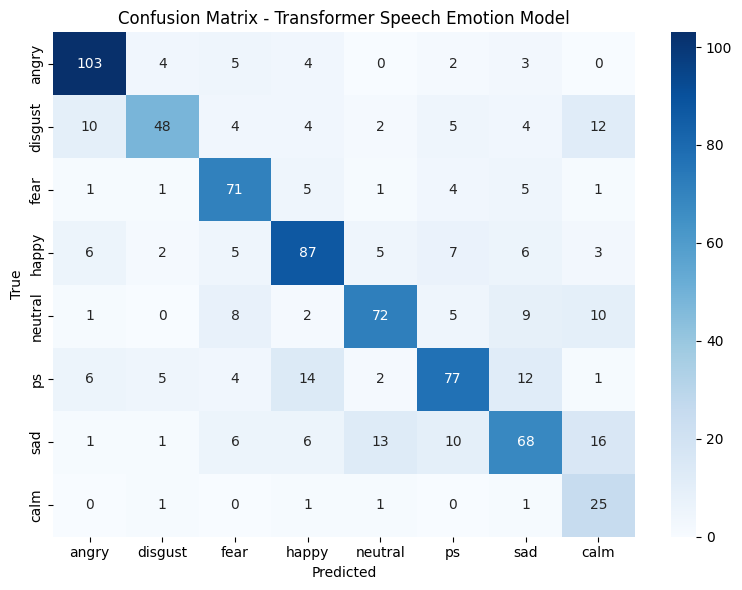

 Saved: confusion_matrix_transformer.png


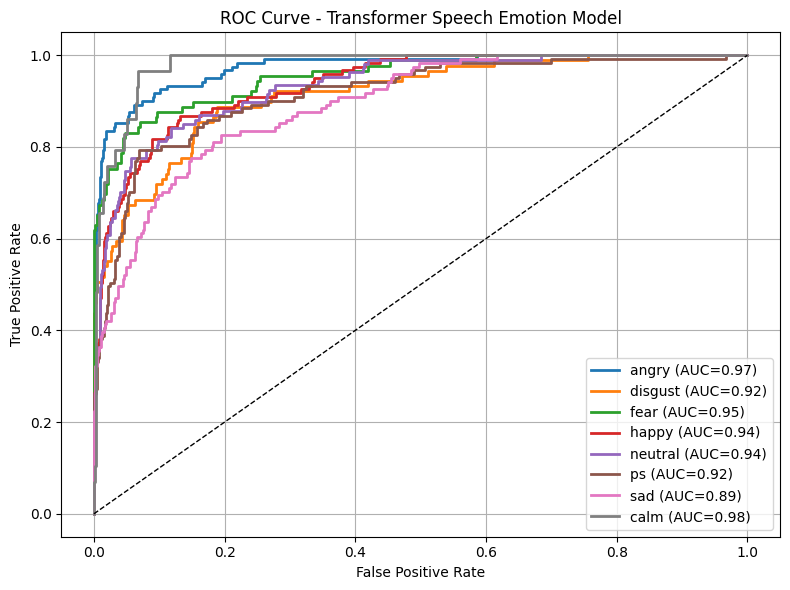

 Saved: roc_curve_transformer.png
 training_curves.pkl not found — save during training with:
    pickle.dump({'train_acc': train_acc_history, 'val_acc': val_acc_history}, open('training_curves.pkl','wb'))


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, Dataset
import pickle

# =====================================================
# DEVICE SETUP
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")
torch.backends.cudnn.benchmark = True

# =====================================================
# MODEL DEFINITION (Transformer + LSTM)
# =====================================================
class TransformerLSTM(nn.Module):
    def __init__(self, num_emotions, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.feature_proj = nn.Linear(40, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=256,
            dropout=0.3, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.lstm = nn.LSTM(d_model, 128, batch_first=True)
        self.fc = nn.Linear(128, num_emotions)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)
        x = self.feature_proj(x)
        x = self.transformer(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)

# =====================================================
# LOAD MODEL
# =====================================================
MODEL_PATH = "./best_transformer_speech_model.pth"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f" Model not found: {MODEL_PATH}")

checkpoint = torch.load(MODEL_PATH, map_location=device)
emotions = checkpoint["emotions"]
num_emotions = len(emotions)

model = TransformerLSTM(num_emotions=num_emotions).to(device)
model.load_state_dict(checkpoint["model"])
model.eval()

print(f" Model loaded with {num_emotions} classes: {emotions}")

# =====================================================
# LOAD CACHED TEST FEATURES (if saved)
# =====================================================
if not os.path.exists("cached_features.pkl"):
    raise FileNotFoundError(" cached_features.pkl not found. Please save it during training.")

with open("cached_features.pkl", "rb") as f:
    X, y, _ = pickle.load(f)

from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        arr = np.expand_dims(self.X[idx], 0)
        return torch.tensor(arr, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

test_loader = DataLoader(EmotionDataset(X_test, y_test), batch_size=32, shuffle=False)

# =====================================================
# COLLECT PREDICTIONS
# =====================================================
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# =====================================================
# CONFUSION MATRIX
# =====================================================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Transformer Speech Emotion Model")
plt.tight_layout()
plt.savefig("confusion_matrix_transformer_speech.png")
plt.show()
print(" Saved: confusion_matrix_transformer.png")

# =====================================================
# ROC CURVE (multi-class)
# =====================================================
y_bin = label_binarize(all_labels, classes=list(range(num_emotions)))

plt.figure(figsize=(8, 6))
for i in range(num_emotions):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{emotions[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Transformer Speech Emotion Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_transformer_speech.png")
plt.show()
print(" Saved: roc_curve_transformer.png")

# =====================================================
# TRAINING CURVES (if available)
# =====================================================
if os.path.exists("training_curves.pkl"):
    with open("training_curves.pkl", "rb") as f:
        curves = pickle.load(f)
    plt.figure(figsize=(8, 5))
    plt.plot(curves["train_acc"], label="Train Accuracy", color="green")
    plt.plot(curves["val_acc"], label="Validation Accuracy", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("training_accuracy_curve_transformer_speech.png")
    plt.show()
    print(" Saved: training_accuracy_curve_transformer.png")
else:
    print(" training_curves.pkl not found — save during training with:")
    print("    pickle.dump({'train_acc': train_acc_history, 'val_acc': val_acc_history}, open('training_curves.pkl','wb'))")


In [ ]:
#directories
data_dirs = [
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\voice_data\\train_data\\SER",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_01",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_02",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_03",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_04",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_05",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_06",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_07",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_08",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_09",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_10",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_11",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_12",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_13",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_14",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_15",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_16",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_17",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_18",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_19",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_20",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_21",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_22",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_23",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive\\audio_speech_actors_01-24\\Actor_24",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Angry",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Happy",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Natural",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Sad",
    "K:\\Code\\Project\\Research Paper\\Emotion Detection\\archive2\\Surprised"
]